In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision.transforms as T
from torchvision.io import read_image
import matplotlib.pyplot as plt
from ultralytics import YOLO
from torchcam.methods import SmoothGradCAMpp
from pathlib import Path
import torch.nn as nn
import cv2
from tqdm import tqdm

In [2]:
# 2. Define rotate and augmentation functions (fix indentation and image extension if needed)

def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)

    # Compute rotation matrix and perform rotation
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)

def augment_in_place(dataset_root, angles=[45, 90, 135]):
    dataset_root = Path(dataset_root)
    splits = ['train', 'test']
    classes = ['ok_front', 'def_front']

    for split in splits:
        for cls in classes:
            img_dir = dataset_root / split / cls
            images = list(img_dir.glob('*.jpeg'))  # Change to '*.jpg' if your images are jpg

            for img_path in tqdm(images, desc=f'Augmenting {split}/{cls}'):
                image = cv2.imread(str(img_path))
                base_name = img_path.stem

                for angle in angles:
                    rotated = rotate_image(image, angle)
                    new_name = f"{base_name}_rot{angle}.jpeg"
                    cv2.imwrite(str(img_dir / new_name), rotated)

In [3]:
# 3. Set your local dataset path

dataset_path = r'C:\Users\me1mna\Downloads\archive (3)\casting_data\casting_data'

In [4]:
# 4. Run augmentation

augment_in_place(dataset_path)

Augmenting test/def_front: 100%|██████████| 453/453 [00:17<00:00, 26.00it/s]


In [5]:
# 5. Setup device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# 6. Create YOLOv8 classification model

model = YOLO('yolov8n-cls.pt')  # n = nano, cls = classification

100%|██████████| 5.31M/5.31M [00:02<00:00, 2.17MB/s]


In [7]:
yaml_content = """
train: C:/Users/me1mna/Downloads/archive (3)/casting_data/casting_data/train
val: C:/Users/me1mna/Downloads/archive (3)/casting_data/casting_data/test

nc: 2
names:
  0: ok_front
  1: def_front
"""

with open("casting_data.yaml", "w") as f:
    f.write(yaml_content.strip())
print("casting_data.yaml created successfully.")

casting_data.yaml created successfully.


In [10]:
import os

# Check current working directory
print("Current working directory:", os.getcwd())

# Set working directory to where your YAML file is located (if needed)
os.chdir(r'C:\Users\me1mna')

# Confirm change
print("Changed working directory to:", os.getcwd())

# Now train

Current working directory: C:\Users\me1mna
Changed working directory to: C:\Users\me1mna


In [12]:
# 7. Train the model on your dataset

model.train(
    data=dataset_path,
    epochs=3,
    imgsz=300,
    batch=40
)

Ultralytics 8.3.170  Python-3.10.18 torch-2.7.1+cpu CPU (13th Gen Intel Core(TM) i9-13950HX)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=40, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\me1mna\Downloads\archive (3)\casting_data\casting_data, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=300, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, pe

train: Scanning C:\Users\me1mna\Downloads\archive (3)\casting_data\casting_data\train... 26532 images, 0 corrupt: 100%|██████████| 26532/26532 [00:33<00:00, 785.25it/s]


train: New cache created: C:\Users\me1mna\Downloads\archive (3)\casting_data\casting_data\train.cache
val: Fast image access  (ping: 0.30.1 ms, read: 21.08.3 MB/s, size: 18.5 KB)


C:\Users\me1mna\AppData\Local\anaconda3\envs\phd_tf\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning C:\Users\me1mna\Downloads\archive (3)\casting_data\casting_data\test... 2860 images, 0 corrupt: 100%|██████████| 2860/2860 [00:03<00:00, 776.98it/s]


val: New cache created: C:\Users\me1mna\Downloads\archive (3)\casting_data\casting_data\test.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.000625), 27 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to runs\classify\train3
Starting training for 3 epochs...

      Epoch    GPU_mem       loss  Instances       Size


C:\Users\me1mna\AppData\Local\anaconda3\envs\phd_tf\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
        1/3         0G     0.6262         40        320:   0%|          | 2/664 [00:07<43:33,  3.95s/it]


        1/3         0G     0.6322         40        320:   0%|          | 3/664 [00:11<44:04,  4.00s/it]
%|█▋        | 128k/755k [00:00<00:00, 1.21MB/s]
%|█████     | 384k/755k [00:00<00:00, 1.54MB/s]
100%|██████████| 755k/755k [00:00<00:00, 1.73MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 36/36 [01:38<00:00,  2.73s/it]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 36/36 [01:39<00:00,  2.76s/it]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 36/36 [01:38<00:00,  2.73s/it]

                   all       0.99          1



3 epochs completed in 2.423 hours.
Optimizer stripped from runs\classify\train3\weights\last.pt, 3.0MB
Optimizer stripped from runs\classify\train3\weights\best.pt, 3.0MB

Validating runs\classify\train3\weights\best.pt...
Ultralytics 8.3.170  Python-3.10.18 torch-2.7.1+cpu CPU (13th Gen Intel Core(TM) i9-13950HX)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
WARNING Dataset 'split=val' not found, using 'split=test' instead.
train: C:\Users\me1mna\Downloads\archive (3)\casting_data\casting_data\train... found 26532 images in 2 classes  
val: C:\Users\me1mna\Downloads\archive (3)\casting_data\casting_data\test... found 2860 images in 2 classes  
test: C:\Users\me1mna\Downloads\archive (3)\casting_data\casting_data\test... found 2860 images in 2 classes  


               classes   top1_acc   top5_acc: 100%|██████████| 36/36 [01:26<00:00,  2.40s/it]


                   all      0.994          1
Speed: 0.0ms preprocess, 15.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\train3


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002230EB97700>
curves: []
curves_results: []
fitness: 0.9970279633998871
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9940559267997742, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9970279633998871}
save_dir: WindowsPath('runs/classify/train3')
speed: {'preprocess': 0.0007338461651746835, 'inference': 15.200456293622175, 'loss': 4.723767417815182e-05, 'postprocess': 0.00014944053727195607}
task: 'classify'
top1: 0.9940559267997742
top5: 1.0

In [1]:
from ultralytics import YOLO
model = YOLO('runs/classify/train3/weights/best.pt')  # Adjust path as needed

In [1]:
# Path to your image
img_path = r'C:\Users\me1mna\Downloads\archive (3)\casting_data\casting_data\test\ok_front\cast_ok_0_1316.jpeg'

# Run inference
results = model(img_path)

# Print predicted class and confidence
print(results)

# To visualize the prediction with bounding boxes or labels (for classification, it shows labels)
##results.show()  # This will open a window with the image and prediction overlay

# Or plot inline in Jupyter
plt.imshow(results[0].plot())
plt.axis('off')
plt.show()

NameError: name 'model' is not defined

Original grayscale image shape: (300, 300, 1)
Squeezed grayscale image shape: (300, 300)
Final image_rgb shape: (300, 300, 3)


100%|██████████| 2000/2000 [01:47<00:00, 18.58it/s]


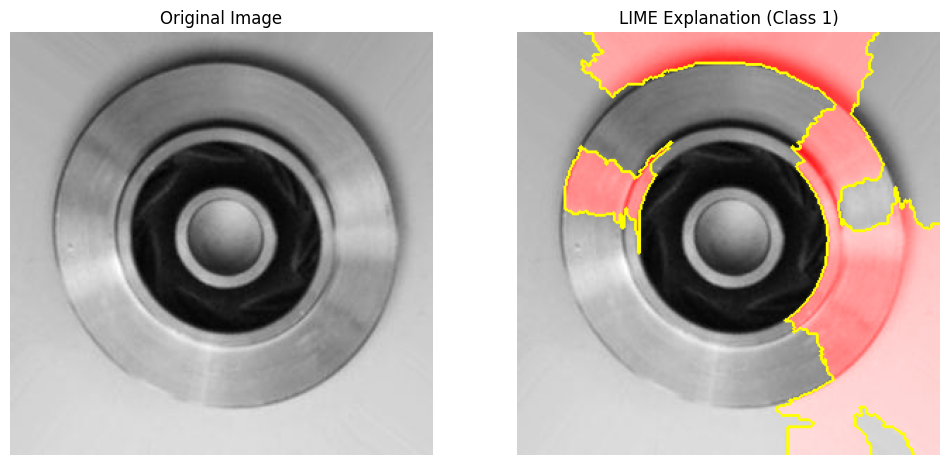

In [6]:
import numpy as np
import cv2
from lime import lime_image
from ultralytics import YOLO
import torchvision.transforms as T
import torch
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
# Define preprocessing transform matching your model's input
transform = T.Compose([
    T.ToTensor(),
    T.Resize((320, 320)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Prediction function for LIME
def predict(images):
    model.model.eval()
    batch = []
    for img in images:
        # img is a numpy array with shape (H, W, 3) in RGB, uint8
        img_tensor = transform(img).unsqueeze(0)  # Add batch dim
        batch.append(img_tensor)
    batch_tensor = torch.cat(batch, dim=0)
    with torch.no_grad():
        outputs = model.model(batch_tensor)[0]  # Get logits tensor from tuple
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
    return probs

# Load grayscale image with OpenCV
image_path = r'C:\Users\me1mna\Downloads\archive (3)\casting_data\casting_data\test\ok_front\cast_ok_0_1316.jpeg'
image_bgr = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
print("Original grayscale image shape:", image_bgr.shape)

# Squeeze extra dimension if present
if image_bgr.ndim == 3 and image_bgr.shape[2] == 1:
    image_bgr = np.squeeze(image_bgr, axis=2)
    print("Squeezed grayscale image shape:", image_bgr.shape)

# Stack grayscale to 3 channels
image_rgb = np.stack([image_bgr]*3, axis=-1)
print("Final image_rgb shape:", image_rgb.shape)

# Ensure image is uint8 dtype for LIME segmentation
if image_rgb.dtype != np.uint8:
    image_rgb = (image_rgb * 255).astype(np.uint8)

# Initialize LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Explain the prediction on the image
explanation = explainer.explain_instance(
    image_rgb,
    predict,
    top_labels=2,
    hide_color=0,
    num_samples=2000  # Increase samples for better explanation quality
)

# Get explanation mask for the top predicted class
top_label = explanation.top_labels[0]

temp, mask = explanation.get_image_and_mask(
    top_label,
    positive_only=False,
    num_features=10,
    hide_rest=False
)

# Fix temp shape and dtype for mark_boundaries
if temp.ndim == 2:
    temp = np.stack([temp]*3, axis=-1)
temp = temp.astype(np.float32) / 255.0

# Visualize
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f'LIME Explanation (Class {top_label})')
plt.imshow(mark_boundaries(temp, mask))
plt.axis('off')

plt.show()

In [3]:
model.eval()

YOLO(
  (model): ClassificationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_

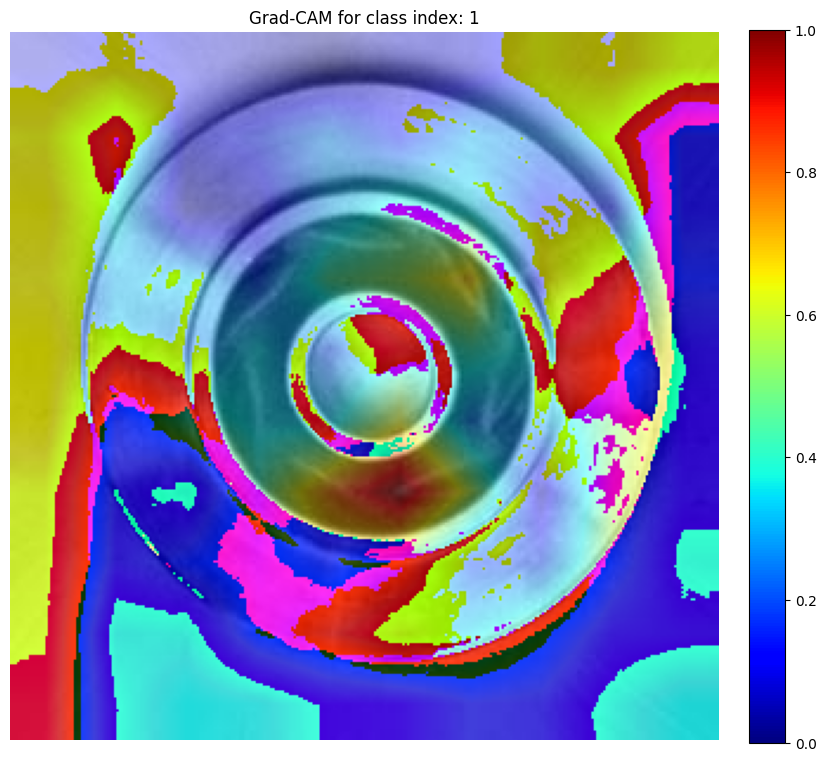

In [9]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchcam.methods import SmoothGradCAMpp
from ultralytics import YOLO
import torchvision.transforms as T
import torch
import torch.nn as nn

class ModelWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        outputs = self.model(x)
        if isinstance(outputs, (tuple, list)):
            return outputs[0]
        return outputs


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

wrapped_model = ModelWrapper(model.model.model)
wrapped_model.to(device)
wrapped_model.eval()

transform = T.Compose([
    T.Resize((320, 320)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],  std=[0.229, 0.224, 0.225])
])

img_path = r'C:\Users\me1mna\Downloads\archive (3)\casting_data\casting_data\test\ok_front\cast_ok_0_1316.jpeg'  # replace with your image path
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_pil = Image.fromarray(img_rgb)
input_tensor = transform(img_pil).unsqueeze(0).to(device)

target_layer = model.model.model[9].conv.conv
cam_extractor = SmoothGradCAMpp(wrapped_model, target_layer=target_layer)

input_tensor.requires_grad_()

with torch.enable_grad():
    outputs = wrapped_model(input_tensor)
    pred_class = outputs.argmax(dim=1).item()

    wrapped_model.zero_grad()
    if input_tensor.grad is not None:
        input_tensor.grad.zero_()

    outputs[0, pred_class].backward()

    activation_map = cam_extractor(pred_class, outputs)

heatmap = activation_map[0].squeeze().cpu().numpy()
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
superimposed_img = heatmap_color * 0.4 + img

fig, ax = plt.subplots(figsize=(10, 10))

# Show the image
im = ax.imshow(cv2.cvtColor(superimposed_img.astype('uint8'), cv2.COLOR_BGR2RGB))
ax.axis('off')
ax.set_title(f'Grad-CAM for class index: {pred_class}')

# Create ScalarMappable for colorbar with the same colormap and normalization
sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])

# Add colorbar to the same axes
fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)

plt.show()

Predicted class index: 0


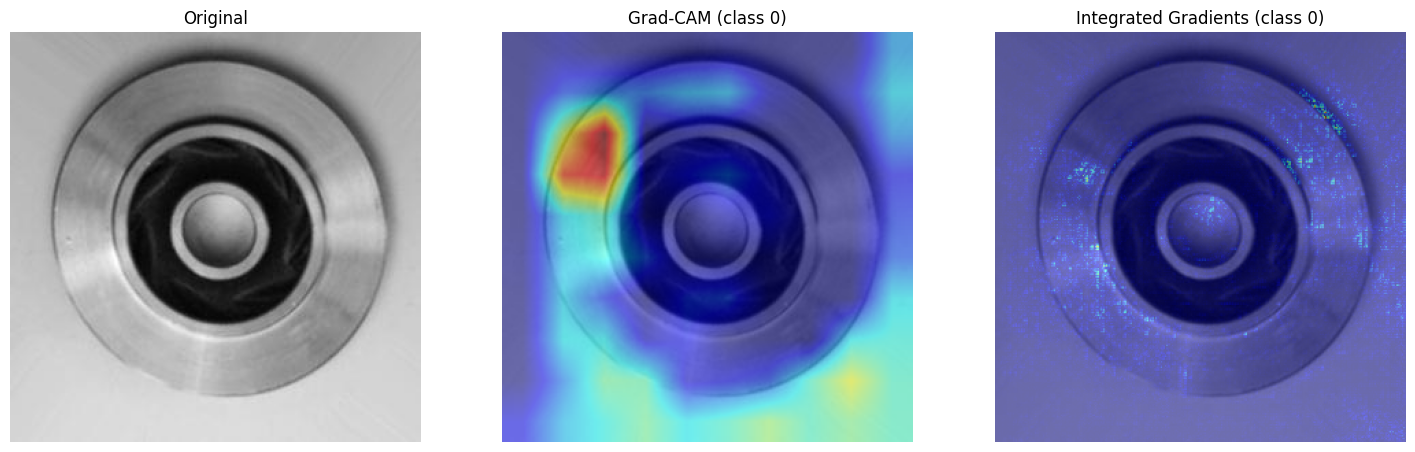

In [7]:
import torch
import torch.nn as nn
from ultralytics import YOLO
from torchvision import transforms as T
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# ----------------------------
# 1) Load YOLOv8 classifier
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo = YOLO("runs/classify/train3/weights/best.pt")   # adjust if needed
net = yolo.model
net.train()   # keep grads alive for attribution

# Wrapper so forward always returns logits
class ModelWrapper(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.m = m
    def forward(self, x):
        out = self.m(x)
        if isinstance(out, (tuple, list)):
            out = out[0]
        return out

wrapped = ModelWrapper(net).to(device)

# ----------------------------
# 2) Preprocessing
# ----------------------------
transform = T.Compose([
    T.Resize((300, 300)),   # match training imgsz
    T.ToTensor(),
    # Drop Normalize if you didn’t use ImageNet stats in training
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

img_path = r"C:\Users\me1mna\Downloads\archive (3)\casting_data\casting_data\test\ok_front\cast_ok_0_1316.jpeg"
bgr = cv2.imread(img_path)
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
inp = transform(Image.fromarray(rgb)).unsqueeze(0).to(device)
inp.requires_grad_(True)

# ----------------------------
# 3) Forward & Prediction
# ----------------------------
scores = wrapped(inp)
pred = int(scores.argmax(dim=1).item())
print("Predicted class index:", pred)

# ----------------------------
# 4) Grad-CAM
# ----------------------------
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Find last conv layer
def last_conv(module: nn.Module):
    last = None
    for m in module.modules():
        if isinstance(m, nn.Conv2d):
            last = m
    return last

target_layer = last_conv(wrapped)

with GradCAM(model=wrapped, target_layers=[target_layer]) as cam:
    grayscale_cam = cam(input_tensor=inp, targets=[ClassifierOutputTarget(pred)])[0]

gradcam_overlay = show_cam_on_image(rgb.astype(np.float32)/255.0,
                                    grayscale_cam, use_rgb=True)

# ----------------------------
# 5) Integrated Gradients
# ----------------------------
from captum.attr import IntegratedGradients

ig = IntegratedGradients(wrapped)
baseline = torch.zeros_like(inp)

# Safe config to avoid OOM
attributions_ig = ig.attribute(
    inp, baselines=baseline, target=pred,
    n_steps=25, internal_batch_size=4
)

attr = attributions_ig[0].detach().cpu().numpy().transpose(1,2,0)
attr = np.mean(np.abs(attr), axis=-1)  # aggregate channels
attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
attr = cv2.resize(attr, (rgb.shape[1], rgb.shape[0]))

ig_heatmap = cv2.applyColorMap(np.uint8(attr*255), cv2.COLORMAP_JET)
ig_overlay = (0.5*ig_heatmap + 0.5*bgr).astype(np.uint8)

# ----------------------------
# 6) Plot comparison
# ----------------------------
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.imshow(rgb)
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gradcam_overlay)
plt.title(f"Grad-CAM (class {pred})")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(ig_overlay, cv2.COLOR_BGR2RGB))
plt.title(f"Integrated Gradients (class {pred})")
plt.axis("off")

plt.show()


Predicted class: ok_front (index 1)


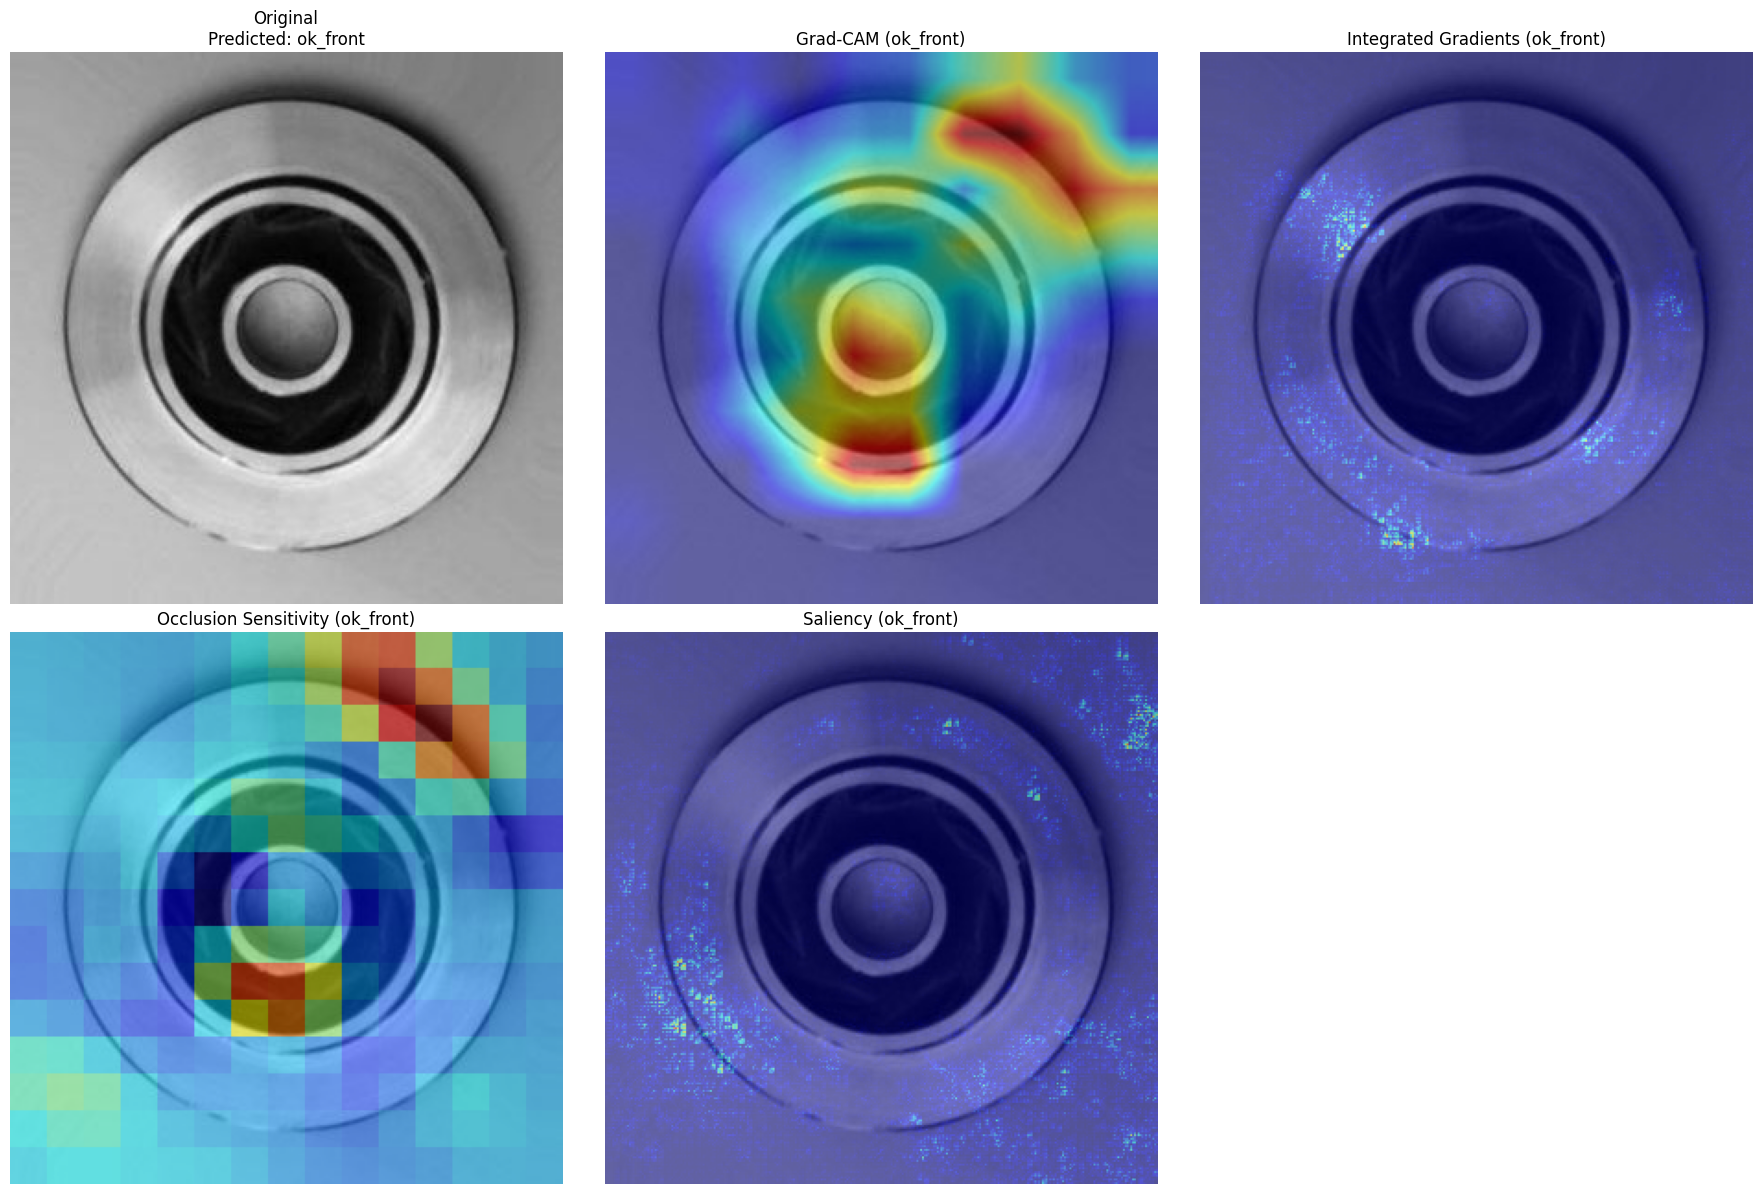

In [7]:
import torch
import torch.nn as nn
from ultralytics import YOLO
from torchvision import transforms as T
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# ----------------------------
# 1) Load YOLOv8 classifier
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo = YOLO("runs/classify/train3/weights/best.pt")   # adjust if needed
net = yolo.model
net.eval()   # keep grads alive for attribution

class ModelWrapper(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.m = m
    def forward(self, x):
        out = self.m(x)
        return out[0] if isinstance(out, (tuple, list)) else out

wrapped = ModelWrapper(net).to(device)

# ----------------------------
# 2) Preprocessing
# ----------------------------
transform = T.Compose([
    T.Resize((300, 300)),   # match your training imgsz
    T.ToTensor(),
    # Drop Normalize if you didn’t use ImageNet stats
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

img_path = r"C:\Users\me1mna\Downloads\archive (3)\casting_data\casting_data\test\ok_front\cast_ok_0_937_rot90.jpeg"
bgr = cv2.imread(img_path)
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
inp = transform(Image.fromarray(rgb)).unsqueeze(0).to(device)
inp.requires_grad_(True)

# ----------------------------
# 3) Prediction
# ----------------------------
scores = wrapped(inp)
pred = int(scores.argmax(dim=1).item())
class_name = yolo.names[pred]   # map index → class name
print(f"Predicted class: {class_name} (index {pred})")

# ----------------------------
# 4) Grad-CAM
# ----------------------------
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

def last_conv(module: nn.Module):
    last = None
    for m in module.modules():
        if isinstance(m, nn.Conv2d):
            last = m
    return last

target_layer = last_conv(wrapped)
with GradCAM(model=wrapped, target_layers=[target_layer]) as cam:
    grayscale_cam = cam(input_tensor=inp, targets=[ClassifierOutputTarget(pred)])[0]
gradcam_overlay = show_cam_on_image(rgb.astype(np.float32)/255.0, grayscale_cam, use_rgb=True)

# ----------------------------
# 5) Integrated Gradients
# ----------------------------
from captum.attr import IntegratedGradients
ig = IntegratedGradients(wrapped)
baseline = torch.zeros_like(inp)

attributions_ig = ig.attribute(
    inp, baselines=baseline, target=pred,
    n_steps=25, internal_batch_size=4   # safe config for GPU
)

attr = attributions_ig[0].detach().cpu().numpy().transpose(1,2,0)
attr = np.mean(np.abs(attr), axis=-1)
attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
attr = cv2.resize(attr, (rgb.shape[1], rgb.shape[0]))
ig_overlay = (0.5*cv2.applyColorMap(np.uint8(attr*255), cv2.COLORMAP_JET) + 0.5*bgr).astype(np.uint8)

# ----------------------------
# 6) Occlusion Sensitivity
# ----------------------------
from captum.attr import Occlusion
occ = Occlusion(wrapped)

attr_occ = occ.attribute(
    inp, target=pred,
    strides=(3, 20, 20),                # (channels, H stride, W stride)
    sliding_window_shapes=(3, 40, 40),  # (channels, H patch, W patch)
    baselines=0
)

hm = attr_occ[0].detach().cpu().numpy().sum(axis=0)
hm = (hm - hm.min()) / (hm.max() - hm.min() + 1e-8)
hm = cv2.resize(hm, (rgb.shape[1], rgb.shape[0]))
occ_overlay = (0.5*cv2.applyColorMap(np.uint8(hm*255), cv2.COLORMAP_JET) + 0.5*bgr).astype(np.uint8)

# ----------------------------
# 7) Saliency (Vanilla Gradients)
# ----------------------------
scores[:, pred].backward(retain_graph=True)
sal = inp.grad[0].detach().cpu().numpy().transpose(1,2,0)
sal = np.max(np.abs(sal), axis=-1)
sal = (sal - sal.min()) / (sal.max() - sal.min() + 1e-8)
sal = cv2.resize(sal, (rgb.shape[1], rgb.shape[0]))
sal_overlay = (0.5*cv2.applyColorMap(np.uint8(sal*255), cv2.COLORMAP_JET) + 0.5*bgr).astype(np.uint8)

# ----------------------------
# 8) Plot all results
# ----------------------------
plt.figure(figsize=(18,12))

plt.subplot(2,3,1)
plt.imshow(rgb)
plt.title(f"Original\nPredicted: {class_name}")
plt.axis("off")

plt.subplot(2,3,2)
plt.imshow(gradcam_overlay)
plt.title(f"Grad-CAM ({class_name})")
plt.axis("off")

plt.subplot(2,3,3)
plt.imshow(cv2.cvtColor(ig_overlay, cv2.COLOR_BGR2RGB))
plt.title(f"Integrated Gradients ({class_name})")
plt.axis("off")

plt.subplot(2,3,4)
plt.imshow(cv2.cvtColor(occ_overlay, cv2.COLOR_BGR2RGB))
plt.title(f"Occlusion Sensitivity ({class_name})")
plt.axis("off")

plt.subplot(2,3,5)
plt.imshow(cv2.cvtColor(sal_overlay, cv2.COLOR_BGR2RGB))
plt.title(f"Saliency ({class_name})")
plt.axis("off")

plt.tight_layout()
plt.show()


✅ Predicted class: def_front (index 0)


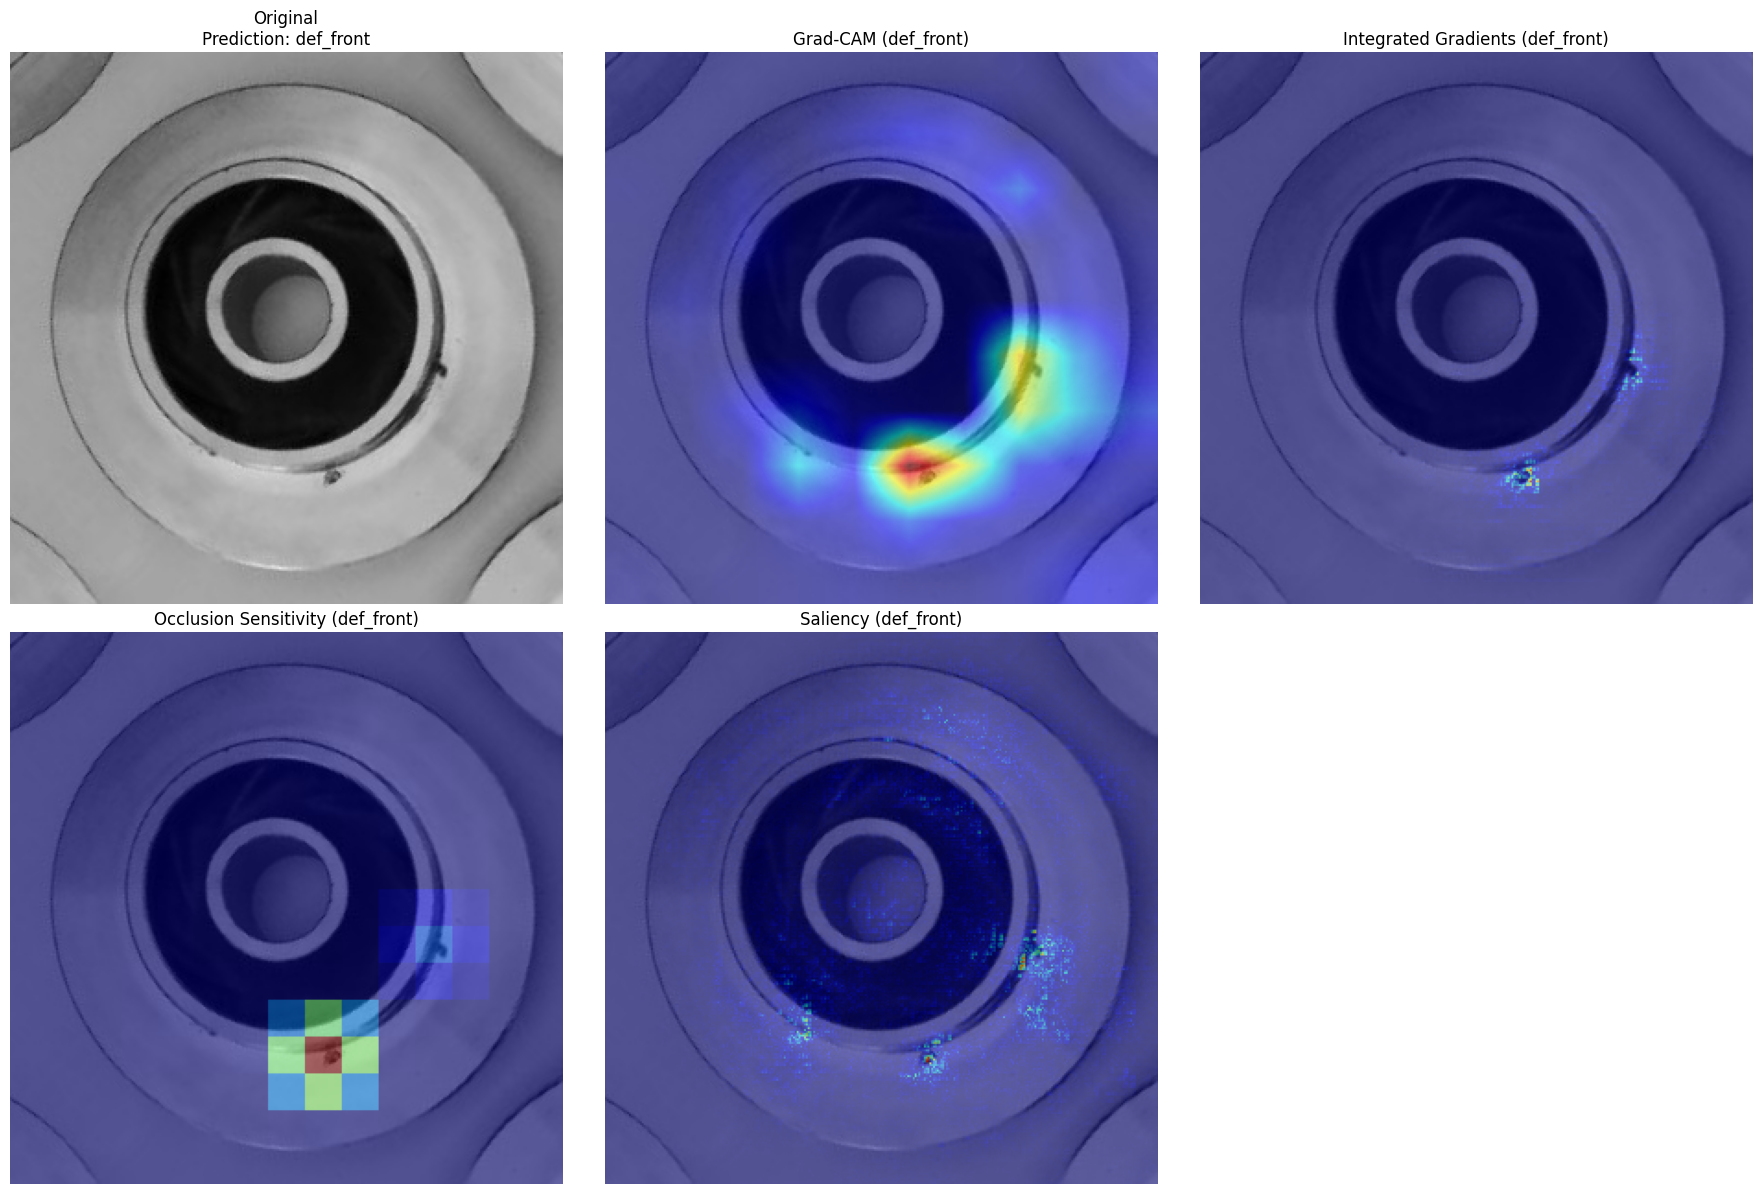

In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from ultralytics import YOLO
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from captum.attr import IntegratedGradients, Occlusion, Saliency

# ----------------------------
# 1) Load trained YOLOv8 classifier
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo = YOLO("runs/classify/train3/weights/best.pt")   # adjust path if needed

net = yolo.model
net.eval()  # ✅ must be in eval mode

# Wrapper to always return logits
class ModelWrapper(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.m = m
    def forward(self, x):
        out = self.m(x)
        return out[0] if isinstance(out, (tuple, list)) else out

wrapped = ModelWrapper(net).to(device)
wrapped.eval()

# ----------------------------
# 2) Preprocessing (no ImageNet normalize!)
# ----------------------------
transform = T.Compose([
    T.Resize((300, 300)),   # match training imgsz
    T.ToTensor(),           # scales to [0,1]
])

# ----------------------------
# 3) Load image
# ----------------------------
img_path = r"C:\Users\me1mna\Downloads\archive (3)\casting_data\casting_data\test\def_front\new__0_7515_rot135.jpeg"
bgr = cv2.imread(img_path)
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
inp = transform(Image.fromarray(rgb)).unsqueeze(0).to(device)
inp.requires_grad_(True)

# ----------------------------
# 4) Prediction
# ----------------------------
scores = wrapped(inp)
pred = int(scores.argmax(dim=1).item())
class_name = yolo.names[pred]
print(f"✅ Predicted class: {class_name} (index {pred})")

# ----------------------------
# 5) Grad-CAM
# ----------------------------
def last_conv(module: nn.Module):
    last = None
    for m in module.modules():
        if isinstance(m, nn.Conv2d):
            last = m
    return last

target_layer = last_conv(wrapped)
with GradCAM(model=wrapped, target_layers=[target_layer]) as cam:
    grayscale_cam = cam(input_tensor=inp, targets=[ClassifierOutputTarget(pred)])[0]

gradcam_overlay = show_cam_on_image(rgb.astype(np.float32)/255.0, grayscale_cam, use_rgb=True)

# ----------------------------
# 6) Integrated Gradients
# ----------------------------
ig = IntegratedGradients(wrapped)
baseline = torch.zeros_like(inp)

attributions_ig = ig.attribute(inp, baselines=baseline, target=pred,
                               n_steps=25, internal_batch_size=4)

attr = attributions_ig[0].detach().cpu().numpy().transpose(1,2,0)
attr = np.mean(np.abs(attr), axis=-1)
attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
attr = cv2.resize(attr, (rgb.shape[1], rgb.shape[0]))
ig_overlay = (0.5*cv2.applyColorMap(np.uint8(attr*255), cv2.COLORMAP_JET) + 0.5*bgr).astype(np.uint8)

# ----------------------------
# 7) Occlusion Sensitivity
# ----------------------------
occ = Occlusion(wrapped)
attr_occ = occ.attribute(inp, target=pred,
                         strides=(3, 20, 20),
                         sliding_window_shapes=(3, 40, 40),
                         baselines=0)

hm = attr_occ[0].detach().cpu().numpy().sum(axis=0)
hm = (hm - hm.min()) / (hm.max() - hm.min() + 1e-8)
hm = cv2.resize(hm, (rgb.shape[1], rgb.shape[0]))
occ_overlay = (0.5*cv2.applyColorMap(np.uint8(hm*255), cv2.COLORMAP_JET) + 0.5*bgr).astype(np.uint8)

# ----------------------------
# 8) Saliency (Vanilla Gradients)
# ----------------------------
scores[:, pred].backward(retain_graph=True)
sal = inp.grad[0].detach().cpu().numpy().transpose(1,2,0)
sal = np.max(np.abs(sal), axis=-1)
sal = (sal - sal.min()) / (sal.max() - sal.min() + 1e-8)
sal = cv2.resize(sal, (rgb.shape[1], rgb.shape[0]))
sal_overlay = (0.5*cv2.applyColorMap(np.uint8(sal*255), cv2.COLORMAP_JET) + 0.5*bgr).astype(np.uint8)

# ----------------------------
# 9) Plot results
# ----------------------------
plt.figure(figsize=(18,12))

plt.subplot(2,3,1)
plt.imshow(rgb)
plt.title(f"Original\nPrediction: {class_name}")
plt.axis("off")

plt.subplot(2,3,2)
plt.imshow(gradcam_overlay)
plt.title(f"Grad-CAM ({class_name})")
plt.axis("off")

plt.subplot(2,3,3)
plt.imshow(cv2.cvtColor(ig_overlay, cv2.COLOR_BGR2RGB))
plt.title(f"Integrated Gradients ({class_name})")
plt.axis("off")

plt.subplot(2,3,4)
plt.imshow(cv2.cvtColor(occ_overlay, cv2.COLOR_BGR2RGB))
plt.title(f"Occlusion Sensitivity ({class_name})")
plt.axis("off")

plt.subplot(2,3,5)
plt.imshow(cv2.cvtColor(sal_overlay, cv2.COLOR_BGR2RGB))
plt.title(f"Saliency ({class_name})")
plt.axis("off")

plt.tight_layout()
import matplotlib.pyplot as plt


# Save the figure
plt.savefig("def.png", dpi=300, bbox_inches="tight")  # save as PNG
plt.savefig("def.pdf", dpi=300, bbox_inches="tight")  # save as PDF

plt.show()
plt.show()
